In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import pickle
import seaborn as sns
import skimage
import sys

ampis_root = pathlib.Path('../../../src/')
assert ampis_root.is_dir()
sys.path.append(str(ampis_root))

from ampis.analyze import align_instance_sets
sys.path.append('../')
from characterize_powder import powder_satellite_image

In [16]:
with open('powder_particle_cval_validation_instance_sets.pickle', 'rb') as f:
    particles = pickle.load(f)
with open('satellite_cval_validation_instance_sets.pickle', 'rb') as f:
    satellites = pickle.load(f)

def unpack(x):
    """
    x is a nested list of objects
    """
    y = []
    for sublist in x:
        for item in sublist:
            y.append(item)
    return y

particles_gt_instances = unpack(particles['gt_val'])
particles_pred_instances = unpack(particles['pred_val'])
        

for gt, pred in zip(particles_gt_instances, particles_pred_instances):
    assert gt.filepath.name == pred.filepath
    pred.filepath = gt.filepath


satellites_gt_instances = unpack(satellites['gt_val'])
satellites_pred_instances = unpack(satellites['pred_val'])

for gt, pred in zip(satellites_gt_instances, satellites_pred_instances):
    assert gt.filepath.name == pred.filepath
    pred.filepath = gt.filepath



In [17]:
# only keep gt satellites with corresponding particle masks drawn
particles_gt_matched, satellites_gt_matched = align_instance_sets(particles_gt_instances, satellites_gt_instances)
# makes sure order of particle predictions is same as particle gt
particles_gt_matched, particles_pred_matched = align_instance_sets(particles_gt_matched, particles_pred_instances)
# only keep pred instances with corresponding satellites
particles_pred_matched, satellites_pred_matched = align_instance_sets(particles_pred_matched, satellites_pred_instances)

In [29]:
psi_gt = [powder_satellite_image(x, y) for x, y in zip(particles_gt_matched, satellites_gt_matched)]
psi_pred =[powder_satellite_image(x, y) for x, y in zip(particles_pred_matched, satellites_pred_matched)]

for pred_or_gt in [psi_gt, psi_pred]:
    for psi in pred_or_gt:
        assert psi.particles.filepath == psi.satellites.filepath
        psi.particles.img = skimage.io.imread(psi.particles.filepath, as_gray=True)
        psi.compute_matches()


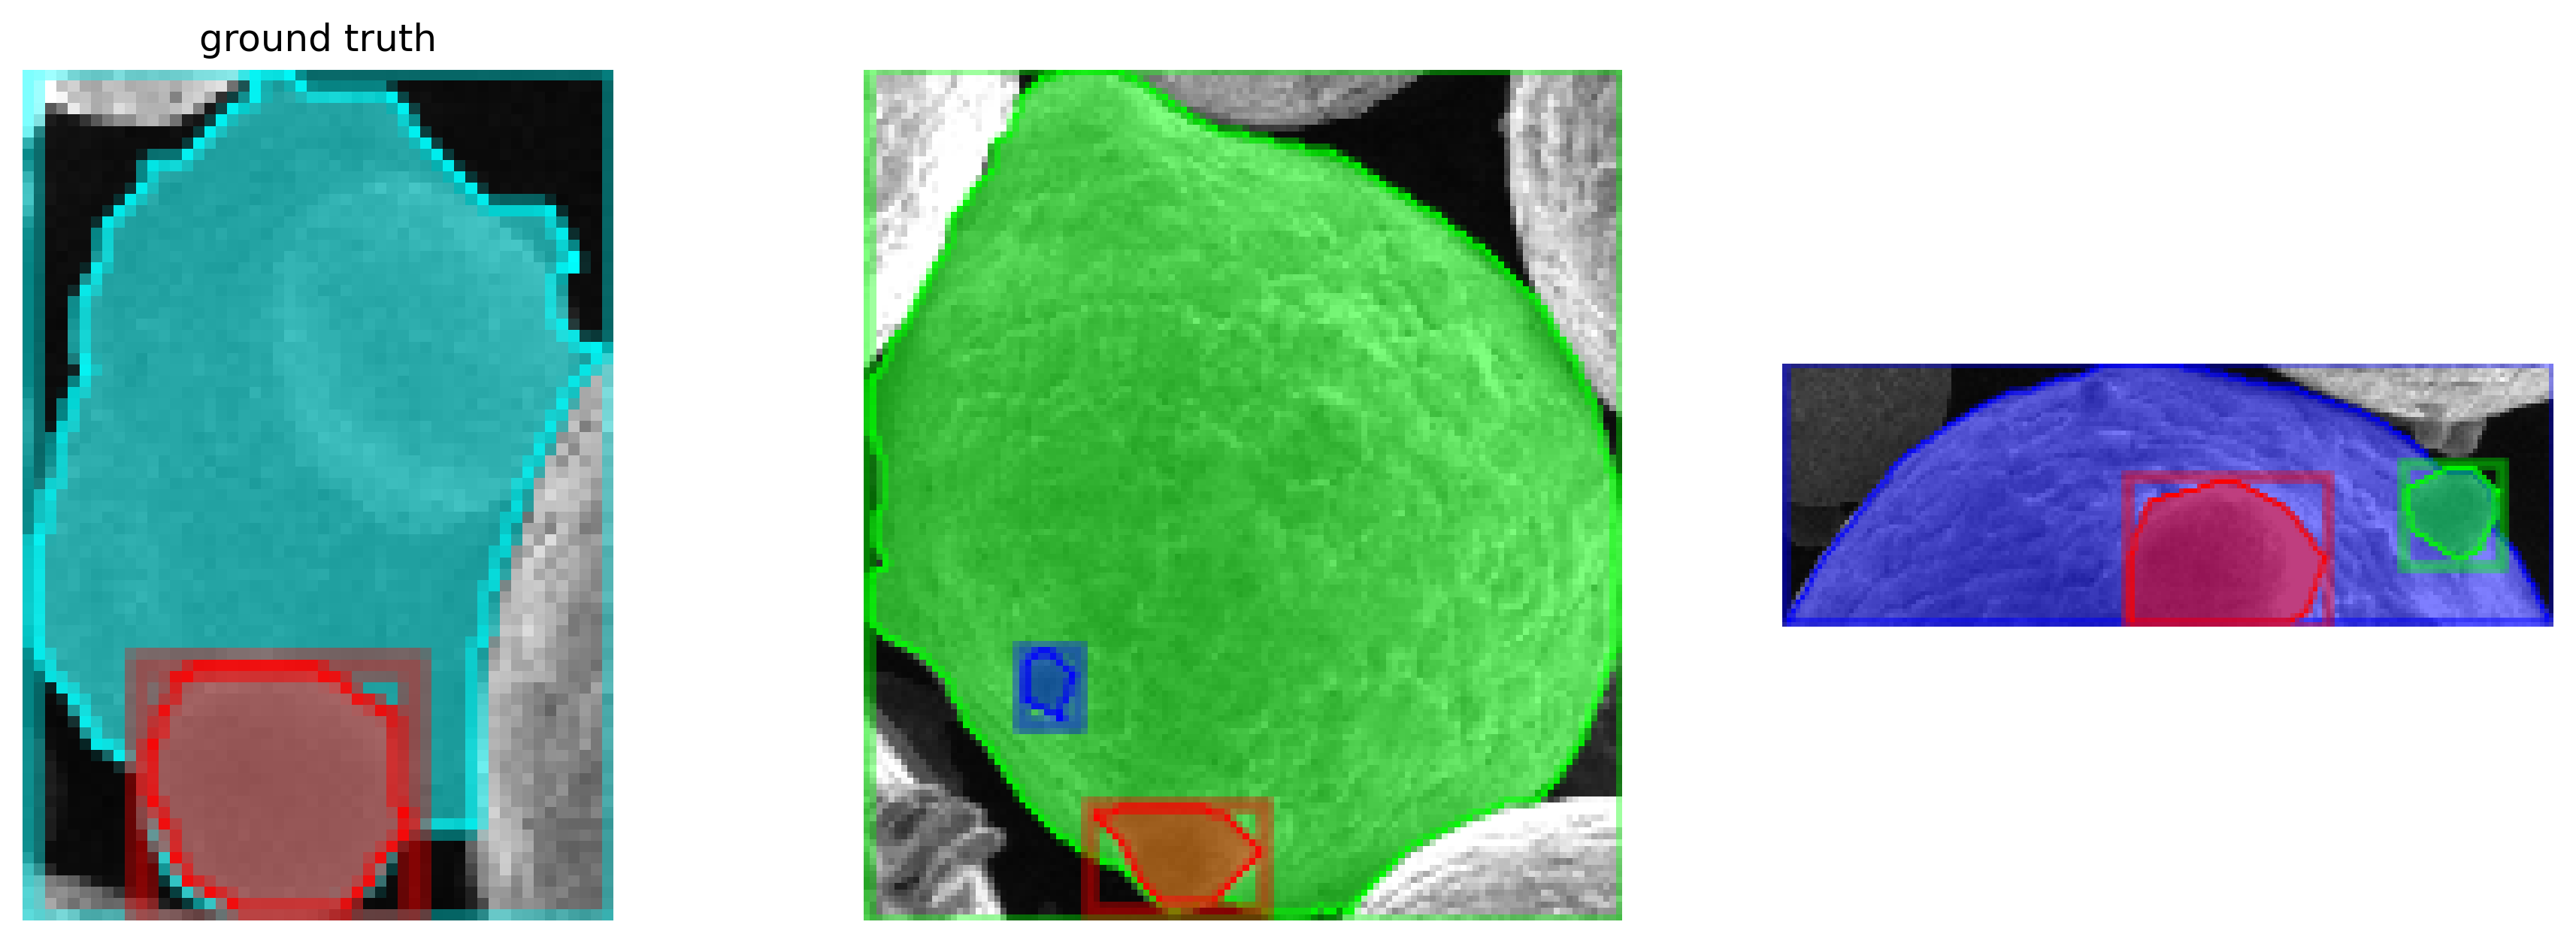

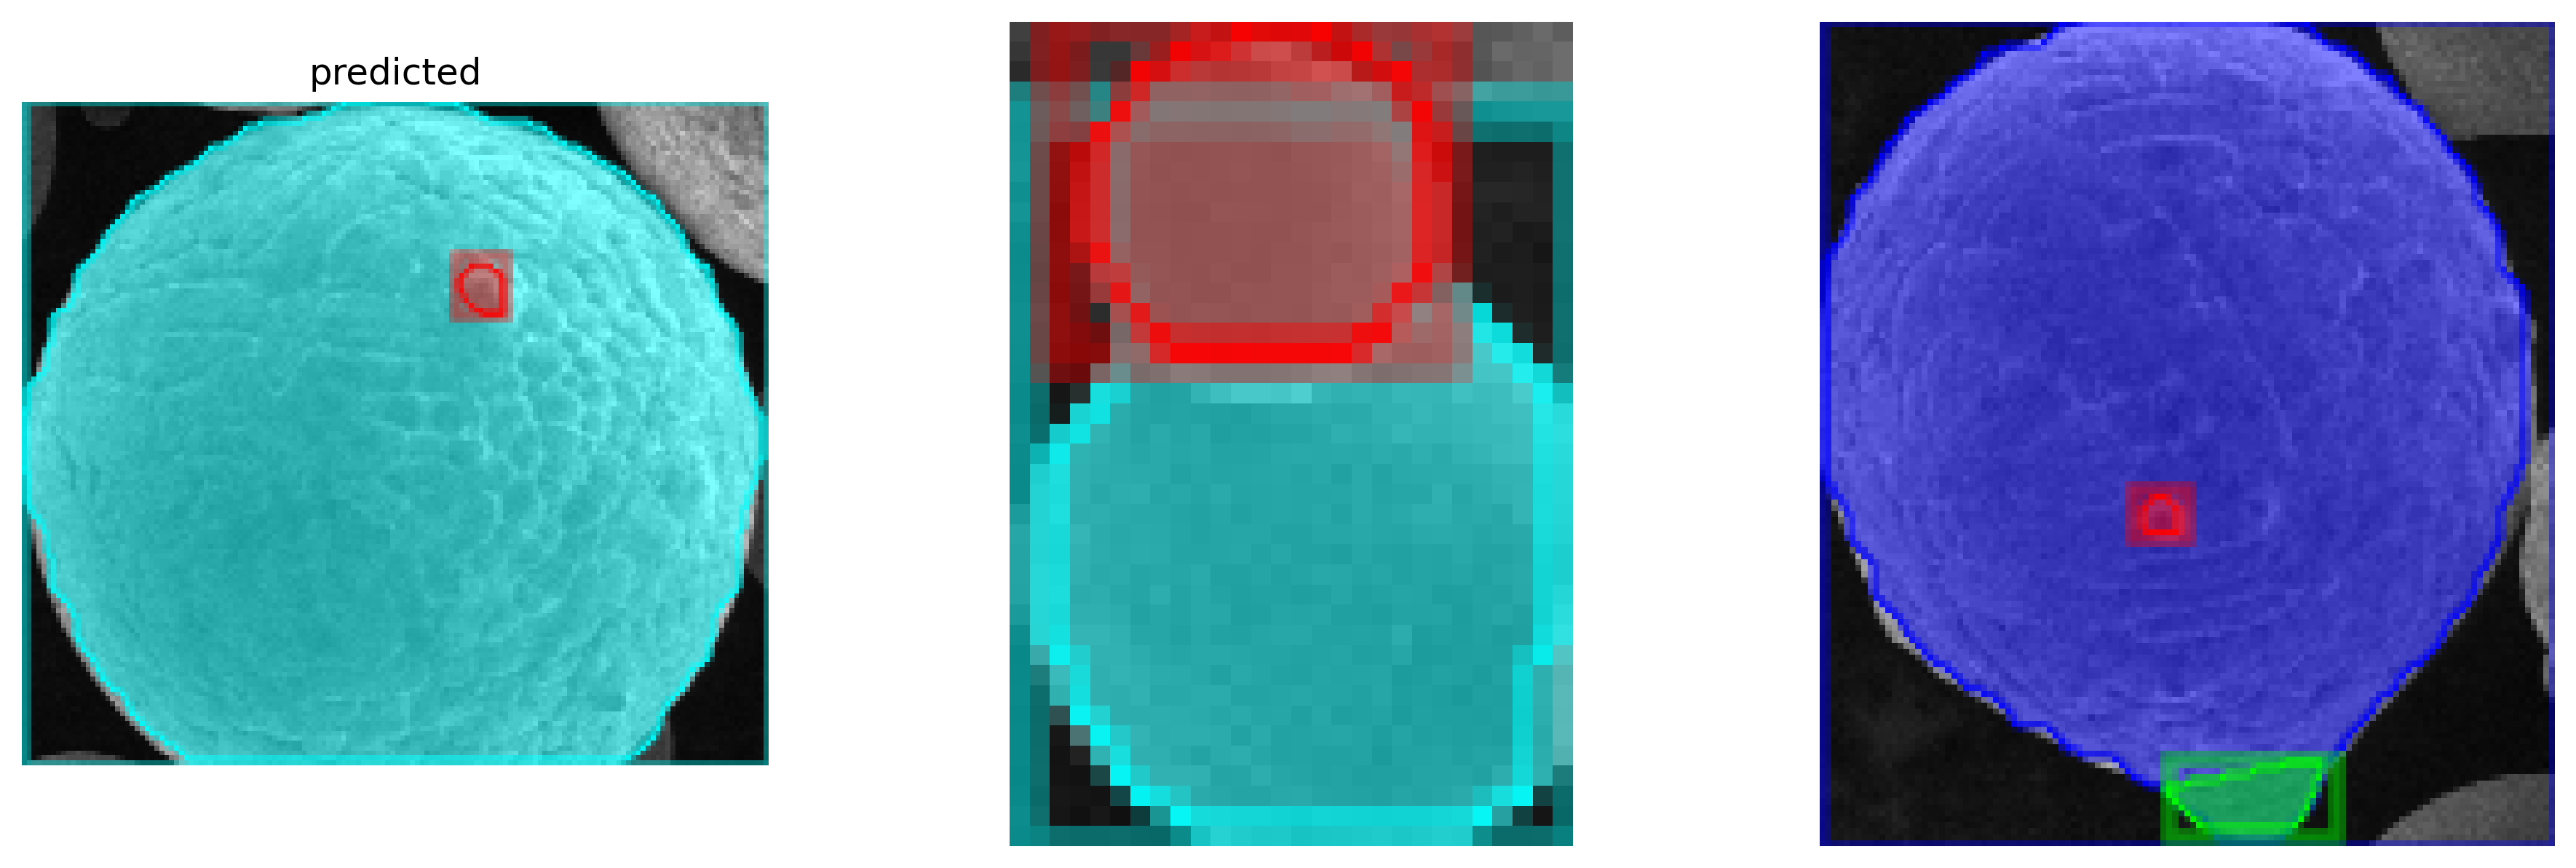

In [32]:
fig, ax = plt.subplots(1,3, figsize=(15,5), dpi=300)
for i, a in zip(np.random.choice(list(psi_gt[0].matches['match_pairs'].keys()), size=3, replace=False),
                 ax.ravel()):
    psi_gt[0].visualize_particle_with_satellites(i, a)
ax[0].set_title('ground truth')    
fig, ax = plt.subplots(1,3, figsize=(15,5), dpi=300)
for i, a in zip(np.random.choice(list(psi_pred[0].matches['match_pairs'].keys()), size=3, replace=False),
                 ax.ravel()):
    psi_pred[0].visualize_particle_with_satellites(i, a)
ax[0].set_title('predicted')
plt.show()

In [9]:
psi_gt.matches.keys()

dict_keys(['satellite_matches', 'satellites_unmatched', 'particles_unmatched', 'intersection_scores', 'match_pairs'])

In [33]:
gt_n = np.array([len(psi.matches['match_pairs']) for psi in psi_gt], np.int)
pred_n = np.array([len(psi.matches['match_pairs']) for psi in psi_pred], np.int)

In [36]:
pred_n/gt_n

array([0.94545455, 0.68493151, 0.79069767, 1.10204082, 1.        ])

In [40]:
print('Number of particles with satellites:\n\tgt: {}\n\tpred: {}\n\tratio: {:.3f}'.format(gt_n.sum(), pred_n.sum(), pred_n.sum()/gt_n.sum()))

Number of particles with satellites:
	gt: 315
	pred: 276
	ratio: 0.876
